In [53]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd
import loompy

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.2 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3
squidpy==1.0.0


In [61]:
def vsn_normalize(arr):
    import logging
    import rpy2.rinterface_lib.callbacks
    rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    import rpy2.robjects as robjects
    robjects.globalenv['arr'] = arr
    arr = robjects.r('''
            library(vsn)
            arr <- t(arr)
            arr[is.nan(arr)] = NA
            fit <- vsnMatrix(arr)
            arr <- t(vsn::predict(fit,arr))
            arr[is.na(arr)] <- 0
            arr
            ''')
    return arr

In [54]:
adata = sc.read_visium('/home/dbdimitrov/Repos/ligrec_decoupleR/input/human_breast_cancer',
                       count_file="filtered.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [57]:
adata

AnnData object with n_obs × n_vars = 4325 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [37]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [38]:
adata

AnnData object with n_obs × n_vars = 4325 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<AxesSubplot:xlabel='n_genes_by_counts'>

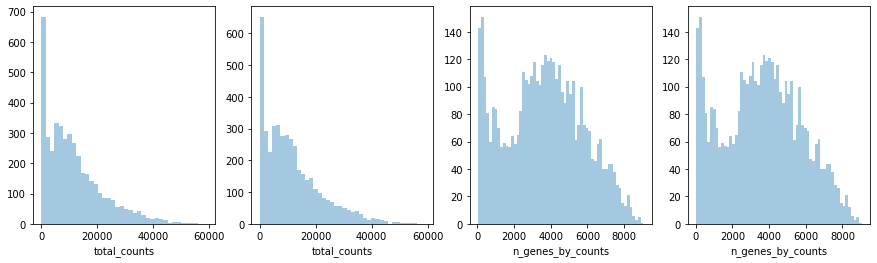

In [39]:
# QC and Processing
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 100000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 10000], kde=False, bins=60, ax=axs[3])

In [62]:
# Normalize and HVF
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 4325 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [63]:
# Manifold embedding and clustering based on transcriptional similarity
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")
adata

AnnData object with n_obs × n_vars = 4325 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


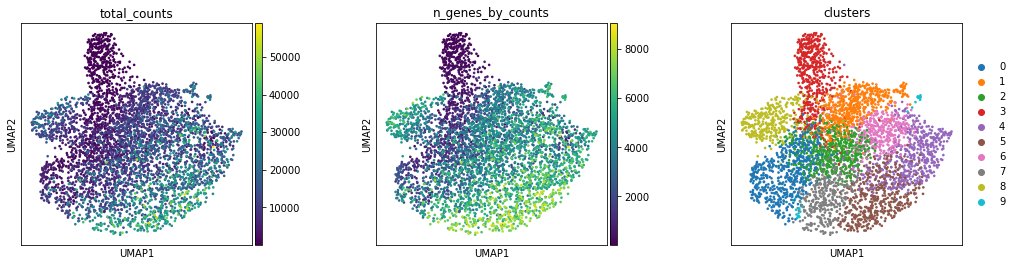

In [42]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

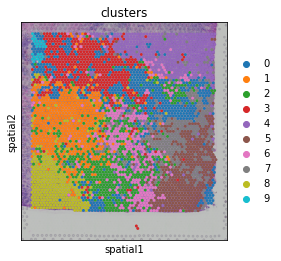

In [43]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

In [44]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="clusters")

  0%|          | 0/1000 [00:00<?, ?/s]

/home/dbdimitrov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


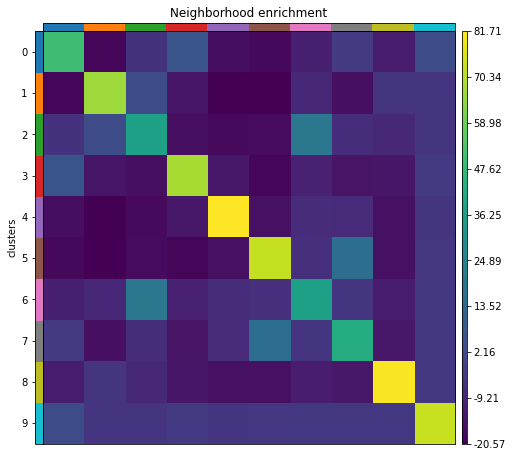

In [45]:
sq.pl.nhood_enrichment(adata, cluster_key="clusters")

In [46]:
sq.gr.nhood_enrichment(adata, cluster_key="clusters")

  0%|          | 0/1000 [00:00<?, ?/s]

In [47]:
adata.uns['clusters_nhood_enrichment']['zscore']

array([[ 50.17005433, -17.85075876,  -5.62828279,   6.02738333,
        -16.67021047, -17.40785507, -11.66218999,  -3.01898194,
        -12.74622913,   3.08935403],
       [-17.85075876,  65.56690175,   2.65417158, -14.56255558,
        -20.33731554, -21.50898706,  -8.6875505 , -16.83375612,
         -4.80938756,  -4.9546221 ],
       [ -5.62828279,   2.65417158,  38.2168746 , -16.62710507,
        -18.76749909, -17.77273651,  19.9214198 ,  -7.31295827,
         -8.75346247,  -4.77632642],
       [  6.02738333, -14.56255558, -16.62710507,  69.28094143,
        -14.80321792, -19.18902998, -11.78643958, -15.30893214,
        -13.54307007,  -3.15201053],
       [-16.67021047, -20.33731554, -18.76749909, -14.80321792,
         79.18403154, -16.00666506,  -7.27247665,  -7.98396939,
        -15.81965898,  -4.7653812 ],
       [-17.40785507, -21.50898706, -17.77273651, -19.18902998,
        -16.00666506,  74.5618909 ,  -6.50875938,  17.01498597,
        -16.54253001,  -4.45649472],
       [-1

In [48]:
array = adata.uns['clusters_nhood_enrichment']['zscore']
pd.DataFrame(np.row_stack(array))

,0,1,2,3,4,5,6,7,8,9
0,50.170054,-17.850759,-5.628283,6.027383,-16.670210,-17.407855,-11.662190,-3.018982,-12.746229,3.089354
1,-17.850759,65.566902,2.654172,-14.562556,-20.337316,-21.508987,-8.687551,-16.833756,-4.809388,-4.954622
2,-5.628283,2.654172,38.216875,-16.627105,-18.767499,-17.772737,19.921420,-7.312958,-8.753462,-4.776326
3,6.027383,-14.562556,-16.627105,69.280941,-14.803218,-19.189030,-11.786440,-15.308932,-13.543070,-3.152011
4,-16.670210,-20.337316,-18.767499,-14.803218,79.184032,-16.006665,-7.272477,-7.983969,-15.819659,-4.765381
5,-17.407855,-21.508987,-17.772737,-19.189030,-16.006665,74.561891,-6.508759,17.014986,-16.542530,-4.456495
6,-11.662190,-8.687551,19.921420,-11.786440,-7.272477,-6.508759,36.149936,-5.540572,-13.071846,-4.083860
7,-3.018982,-16.833756,-7.312958,-15.308932,-7.983969,17.014986,-5.540572,43.788722,-13.531787,-3.789039
8,-12.746229,-4.809388,-8.753462,-13.543070,-15.819659,-16.542530,-13.071846,-13.531787,80.349431,-3.740641
9,3.089354,-4.954622,-4.776326,-3.152011,-4.765381,-4.456495,-4.083860,-3.789039,-3.740641,69.553752


In [51]:
adata.write("/home/dbdimitrov/Repos/ligrec_decoupleR/input/sc_bc/breast_cancer.h5ad")

In [50]:
help(adata.write)

Help on method write_h5ad in module anndata._core.anndata:

write_h5ad(filename: Union[os.PathLike, NoneType] = None, compression: Union[Literal['gzip', 'lzf'], NoneType] = None, compression_opts: Union[int, Any] = None, force_dense: Union[bool, NoneType] = None, as_dense: Sequence[str] = ()) method of anndata._core.anndata.AnnData instance
    Write `.h5ad`-formatted hdf5 file.
    
    .. note::
       Setting compression to `'gzip'` can save disk space
       but will slow down writing and subsequent reading.
       Prior to v0.6.16, this was the default for parameter `compression`.
    
    Generally, if you have sparse data that are stored as a dense matrix,
    you can dramatically improve performance and reduce disk space
    by converting to a :class:`~scipy.sparse.csr_matrix`::
    
        from scipy.sparse import csr_matrix
        adata.X = csr_matrix(adata.X)
    
    Parameters
    ----------
    filename
        Filename of data file. Defaults to backing file.
    compre

In [52]:
adata

AnnData object with n_obs × n_vars = 4325 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors', 'spatial_neighbors', 'clusters_nhood_enrichment'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities'

### Seurat to Scanpy -> Squidpy NES and Coocc

In [3]:
import anndata2ri
import rpy2
import re
from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython